In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/colab_libs')
import pytorch_warmup as warmup

In [ ]:
%cd /content/drive/MyDrive/golfdb

/content/drive/MyDrive/golfdb


# import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from pathlib import Path
# 한글/마이너스 기호 깨짐 방지
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# Install Nanum gothic font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
# 폰트 파일 경로 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# 기본 폰트 및 마이너스 기호 정상 출력
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
df = pd.read_pickle('data/golfDB.pkl')
vid_dir='data/videos_160'

# 1. 데이터셋 구성 분포 확인

- 선수 성별 (남성/여성)
- 사용된 클럽 유형 (드라이버, 아이언, 웨지 등)
- 촬영 뷰 유형 (face-on, down-the-line, 기타)
- 비디오의 속도 (실시간/슬로우 모션)

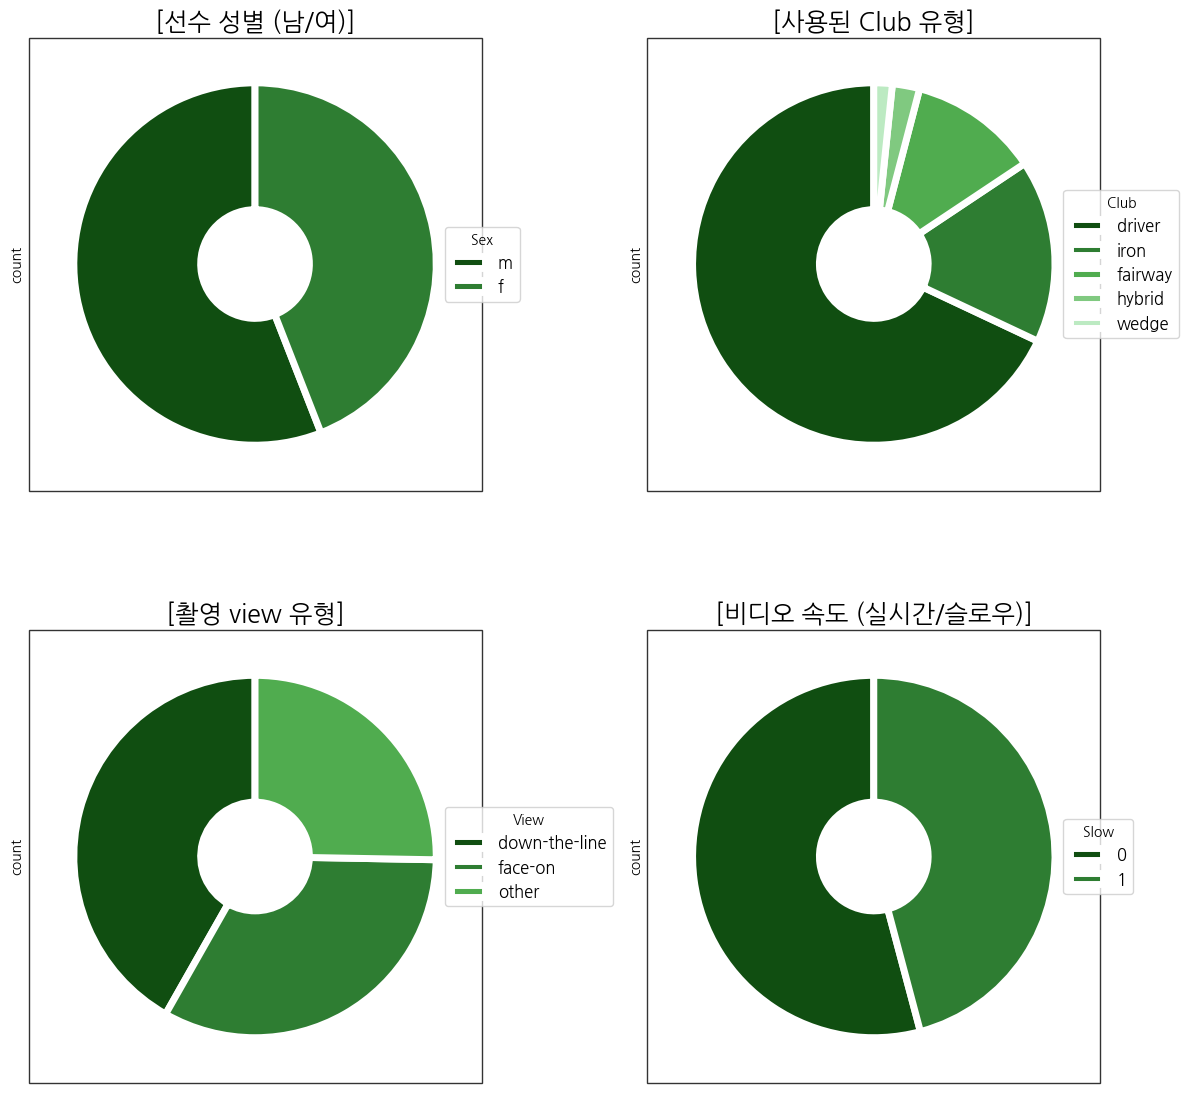

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

colors = ['#104e11', '#2E7D32', '#50ac4f', '#80c980', '#BCEAC2']
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}


labels = df['sex'].value_counts().index
df['sex'].value_counts().plot.pie(
    ax=axes[0, 0],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops,
    # autopct='%1.1f%%',
    textprops={'fontsize': 16}
)
axes[0, 0].legend(
    labels,
    title='Sex',
    loc='center left',
    bbox_to_anchor=(0.9, 0.5),
    fontsize=12
)
axes[0, 0].set_title('[선수 성별 (남/여)]', fontsize=18)


labels = df['club'].value_counts().index
df['club'].value_counts().plot.pie(
    ax=axes[0, 1],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops,
    # autopct='%1.1f%%',
    textprops={'fontsize': 16}
)
axes[0, 1].legend(
    labels,
    title='Club',
    loc='center left',
    bbox_to_anchor=(0.9, 0.5),
    fontsize=12
)
axes[0, 1].set_title('[사용된 Club 유형]', fontsize=18)


labels = df['view'].value_counts().index
df['view'].value_counts().plot.pie(
    ax=axes[1, 0],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops,
    # autopct='%1.1f%%',
    textprops={'fontsize': 16}
)
axes[1, 0].legend(
    labels,
    title='View',
    loc='center left',
    bbox_to_anchor=(0.9, 0.5),
    fontsize=12
)
axes[1, 0].set_title('[촬영 view 유형]', fontsize=18)


labels = df['slow'].value_counts().index
df['slow'].value_counts().plot.pie(
    ax=axes[1, 1],
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops,
    # autopct='%1.1f%%',
    textprops={'fontsize': 16}
)
axes[1, 1].legend(
    labels,
    title='Slow',
    loc='center left',
    bbox_to_anchor=(0.9, 0.5),
    fontsize=12
)
axes[1, 1].set_title('[비디오 속도 (실시간/슬로우)]', fontsize=18)

# 그래프 마다 박스 표시하기
for ax in axes.ravel():
    rect = patches.Rectangle(
        (0, 0), 1, 1,                 # x, y, width, height
        transform=ax.transAxes,       # Axes 좌표계 기준
        fill=False,                   # 내부는 투명
        linewidth=1.0,
        edgecolor='#333333',
        clip_on=False                 # 축 밖까지 그리게
    )
    ax.add_patch(rect)


plt.tight_layout()
plt.show()

# 2. 이벤트 간 프레임 수 (시간) 분석

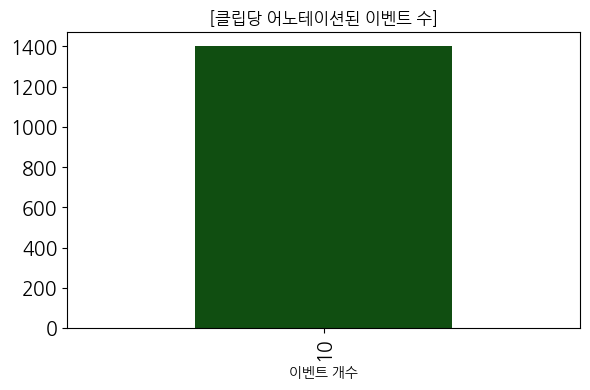

In [ ]:
# 클립별 이벤트 개수
df['n_events'] = df['events'].apply(len)
counts = df['n_events'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 4))

counts.plot.bar(
    ax=ax,
    color='#104e11',
    fontsize=14
)

ax.set_xlabel('이벤트 개수', fontsize=10)
ax.set_title('[클립당 어노테이션된 이벤트 수]', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
df['n_events'].value_counts()

,count
n_events,
10,1400


### 이벤트 간 프레임 간격(구간 길이) 분포

- 이벤트 프레임(Event Frames): 각 비디오 샘플에는 스윙 시퀀스를 구성하는 8가지 핵심 이벤트가 발생하는 정확한 프레임이 수동으로 레이블링되어 있음
  - Address, Toe-up, Mid-backswing, Top, Mid-downswing, Impact, Mid-follow-through, Finish

In [ ]:
df['events']

,events
0,"[408, 455, 473, 476, 490, 495, 498, 501, 514, ..."
1,"[814, 854, 917, 931, 988, 1006, 1019, 1030, 10..."
2,"[521, 659, 678, 683, 692, 696, 698, 701, 715, ..."
3,"[1106, 1190, 1244, 1264, 1300, 1313, 1324, 133..."
4,"[157, 170, 183, 188, 197, 201, 205, 207, 220, ..."
...,...
1395,"[867, 887, 949, 968, 1001, 1017, 1029, 1039, 1..."
1396,"[121, 394, 407, 414, 427, 431, 435, 437, 452, ..."
1397,"[875, 895, 967, 997, 1045, 1061, 1076, 1084, 1..."
1398,"[2585, 2890, 2904, 2912, 2925, 2929, 2932, 293..."


In [ ]:
# 백스윙 프레임 수(Address→Top)
df['back_swing'] = df['events'].apply(lambda ev: ev[3] - ev[0])

# 다운스윙 프레임 수(Top→Impact)
df['down_swing'] = df['events'].apply(lambda ev: ev[5] - ev[3])

# 스윙 템포 계산: 백스윙 프레임 수 ÷ 다운스윙 프레임 수
df['swing_tempo'] = df['back_swing'] / df['down_swing']

- 스윙 템포란,
  - 값 > 1 : 백스윙이 다운스윙보다 느리고 길다는 뜻

  - 값 = 1 : 백스윙과 다운스윙이 같은 속도로 진행

  - 값 < 1 : 다운스윙이 백스윙보다 느리고 더 길다는 뜻


```
[참고]
- 골프에서 “좋은 템포”라고 할 때 흔히 언급되는 것은 백스윙:다운스윙 비율이 3:1 정도, 즉 swing_tempo ≈ 3.0 내외
  - 프로 골퍼들은 백스윙을 더 천천히 가져가면서(리듬을 타고) 다운스윙은 짧고 빠르게 압축해 임팩트를 만들기 때문
  - 반대로 swing_tempo가 너무 작거나(예: 1 미만) 크면(예: 5 이상) 리듬이 깨지거나 과도하게 느린 스윙임을 의미함
```



In [ ]:
df.columns

Index(['id', 'youtube_id', 'player', 'sex', 'club', 'view', 'slow', 'events',
       'bbox', 'split', 'back_swing', 'down_swing', 'n_events', 'swing_tempo'],
      dtype='object')

In [ ]:
df['player'].value_counts()

,count
player,
LYDIA KO,58
MICHELLE WIE,54
TIGER WOODS,53
BROOKE HENDERSON,35
RORY MCILROY,27
...,...
SANG MOON BAE,2
SARAH JANE SMITH,2
MI HYANG LEE,2


In [ ]:
print(df['club'].value_counts())

club
driver     952
iron       229
fairway    162
hybrid      34
wedge       23
Name: count, dtype: int64


In [ ]:
df.groupby('club')['back_swing'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

,count,mean,median,std,min,max
club,,,,,,
driver,952,150.997899,123.0,103.607323,15,1107
fairway,162,144.123457,113.0,101.924815,26,640
hybrid,34,167.470588,121.5,131.034864,26,750
iron,229,146.362445,117.0,96.561246,18,546
wedge,23,165.130435,136.0,114.517289,29,537


In [ ]:
df.groupby('club')['down_swing'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

,count,mean,median,std,min,max
club,,,,,,
driver,952,31.02521,17.0,21.905384,6,136
fairway,162,27.777778,15.0,19.010948,6,73
hybrid,34,29.352941,29.0,18.899867,7,65
iron,229,26.445415,14.0,18.512510,6,67
wedge,23,22.043478,12.0,16.210205,8,57


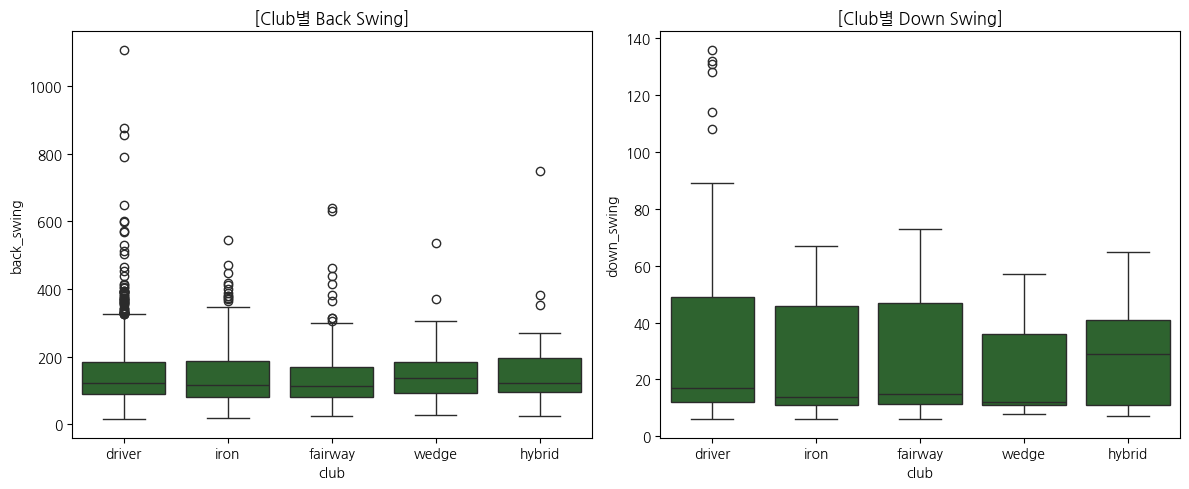

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(x='club', y='back_swing', data=df, ax=axes[0], color='#256c26').set_title('[Club별 Back Swing]')
sns.boxplot(x='club', y='down_swing', data=df, ax=axes[1], color='#256c26').set_title('[Club별 Down Swing]')

plt.tight_layout()

In [ ]:
df.groupby('slow')['swing_tempo'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])

,count,mean,median,std,min,max
slow,,,,,,
0,758,14.779596,12.541958,11.036923,1.25,75.0
1,642,2.578726,2.289899,1.689468,0.757576,31.628571


In [ ]:
df.groupby('slow')['swing_tempo'].value_counts()

slow  swing_tempo
0     4.000000       7
      7.000000       5
      9.000000       4
      11.000000      4
      2.000000       3
                    ..
1     10.976190      1
      12.169231      1
      12.785714      1
      13.074627      1
      31.628571      1
Name: count, Length: 1188, dtype: int64

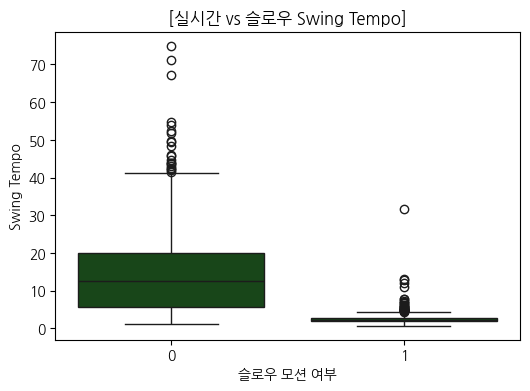

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='slow', y='swing_tempo', data=df, color='#104e11')
plt.xlabel('슬로우 모션 여부', fontsize=10)
plt.ylabel('Swing Tempo')
plt.title('[실시간 vs 슬로우 Swing Tempo]', fontsize=12)
plt.show()


[이벤트별 프레임 수]
count      8.000000
mean     162.375000
std      184.736057
min       19.000000
25%       71.250000
50%       92.500000
75%      165.000000
max      596.000000
dtype: float64

[이벤트별 프레임 수]
Address    596
Toe-Up     213
Mid-BS     149
Top        100
Mid-DS      85
Impact      74
Mid-FT      63
Finish      19


<ipython-input-20-a08d3627a830>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index,


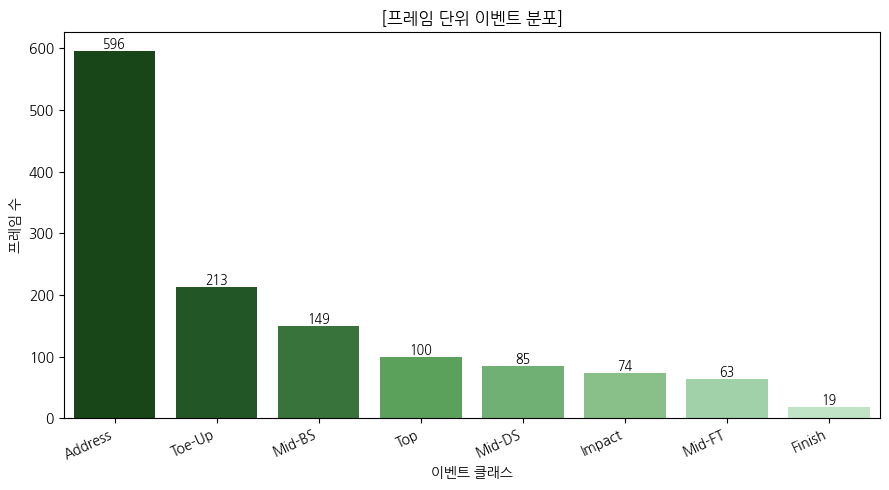

In [ ]:
EVENT_NAMES = [
    'Address', 'Toe-Up', 'Mid-BS', 'Top',
    'Mid-DS', 'Impact', 'Mid-FT', 'Finish']

def build_labels_from_events(events, seq_len=64):
    """
    events : np.array, shape (10,)  -> 첫·마지막 프레임 포함
    반환값  : np.array, shape (seq_len,)  -> 0~8 라벨
    """
    labels = np.full(seq_len, 8, dtype=np.int32)             # 기본: No-Event(8)
    anchor = events[0]                                       # 스윙 시작 프레임
    for cls_idx, ev_frame in enumerate(events[1:-1]):        # 8개 이벤트만
        rel_idx = ev_frame - anchor
        if 0 <= rel_idx < seq_len:
            labels[rel_idx] = cls_idx                        # 각 이벤트 위치에 라벨 부여
    return labels

def plot_event_dist(pkl_path: str, seq_len: int = 64):
    df_path = Path('data/train_split.pkl')
    df = pd.read_pickle(df_path)

    # 1) No-Event 제외 샘플에 대해 프레임 단위 라벨 시퀀스 생성 & 집계
    total_count = np.zeros(8, dtype=np.int64)      # 길이 8 배열
    for ev in df['events']:
        lbl_seq = build_labels_from_events(np.array(ev), seq_len)
        total_count += np.bincount(
            lbl_seq[lbl_seq < 8],          # 0~7만 취합
            minlength=8
        )

    label_counts = pd.Series(total_count, index=EVENT_NAMES)
    print("\n[이벤트별 프레임 수]")
    print(label_counts.describe())

    print("\n[이벤트별 프레임 수]")
    print(label_counts.to_string())

    # 2) 시각화
    plt.figure(figsize=(9, 5))
    colors = ['#104e11', '#1B5E20', '#2E7D32', '#50ac4f', '#66BB6A', '#80c980', '#99D9A4', '#BCEAC2']

    # barplot 결과(=Axes) 를 ax에 저장
    ax = sns.barplot(x=label_counts.index,
                     y=label_counts.values,
                     palette=colors)

    # 막대 위에 값(annotation) 찍기
    for p in ax.patches:
        value = int(p.get_height())
        ax.text(p.get_x() + p.get_width() / 2,
                p.get_height(),
                f'{value:,}',            # 천 단위 콤마
                ha='center', va='bottom',
                fontsize=9, fontweight='bold')

    plt.title('[프레임 단위 이벤트 분포]')
    plt.xlabel('이벤트 클래스')
    plt.ylabel('프레임 수')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_event_dist("train_split.pkl", seq_len=64)
